# 画像処理
MLP(多層パーセプトロン)を使用して手書数字の分類を行う。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

## データ準備

In [2]:
from keras.datasets import mnist
from keras.utils import to_categorical

(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

t_train = to_categorical(t_train)
t_test = to_categorical(t_test)

Using TensorFlow backend.


11493376/11490434 [==============================] - 3s 0us/step


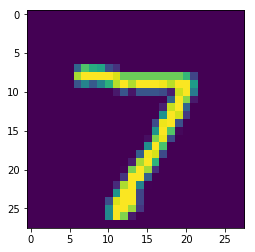

Teach: 7


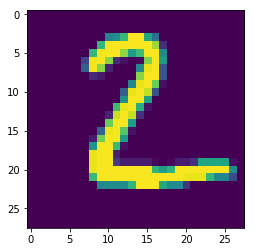

Teach: 2


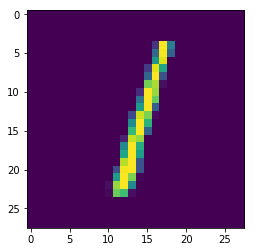

Teach: 1


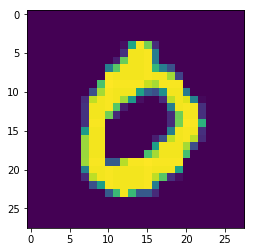

Teach: 0


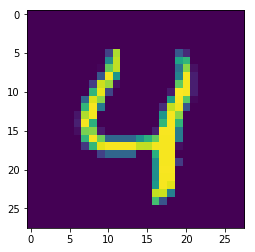

Teach: 4


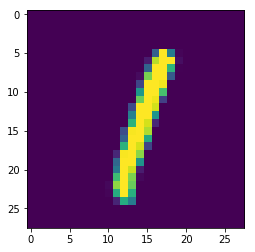

Teach: 1


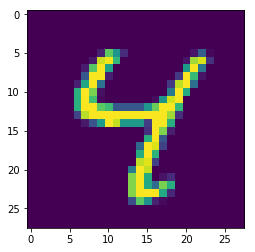

Teach: 4


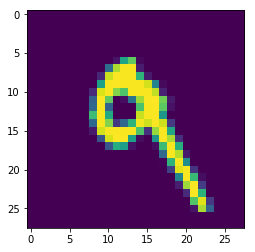

Teach: 9


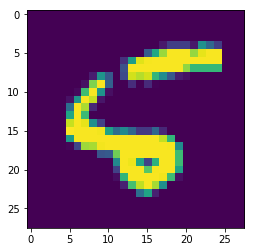

Teach: 5


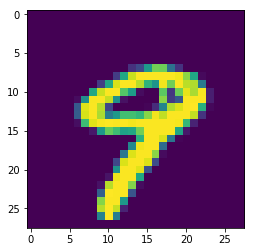

Teach: 9


In [3]:
for idx in range(10):
    img = x_test[idx]
    label = t_test[idx]
    
    plt.imshow(img.reshape(28, 28))
    plt.show()
    
    print("Teach: {0}".format(label.argmax()))

In [4]:
x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

## 活性化関数

- Rectified Linear Unit

In [5]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

- Sigmoid

In [6]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

- Softmax

In [7]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

## レイヤ

- 全結合層

In [8]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

- 出力層

In [9]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

## 損失関数

In [10]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

## 勾配計算
数値微分には計算時間を要するため、実際には、逆誤差伝搬法によって重み行列とバイアスの微分を計算する。

In [11]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

## モデルのクラス定義

In [12]:
from collections import OrderedDict

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

## ハイパーパラメータ設定

In [13]:
# Hyper parameters
ITERS_NUM = 10000
BATCH_SIZE = 100
LEARNING_RATE = 0.1

TRAIN_SIZE = x_train.shape[0]
INPUT_SIZE = x_train.shape[1]
HIDDEN_SIZE = 50
OUTPUT_SIZE = 10

## モデルのインスタンス生成

In [14]:
network = TwoLayerNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

## 学習

In [15]:
from numpy import random

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(TRAIN_SIZE / BATCH_SIZE, 1)

for i in range(ITERS_NUM):
    batch_mask = random.choice(TRAIN_SIZE, BATCH_SIZE)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= LEARNING_RATE * grad[key]
    
    train_loss_list.append(network.loss(x_batch, t_batch))
    
    if i % iter_per_epoch == 0:
        print("Iterations: {0}".format(i))
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

Iterations: 0
Iterations: 600
Iterations: 1200
Iterations: 1800
Iterations: 2400
Iterations: 3000
Iterations: 3600
Iterations: 4200
Iterations: 4800
Iterations: 5400
Iterations: 6000
Iterations: 6600
Iterations: 7200
Iterations: 7800
Iterations: 8400
Iterations: 9000
Iterations: 9600


## 学習結果

### 損失関数の値の推移

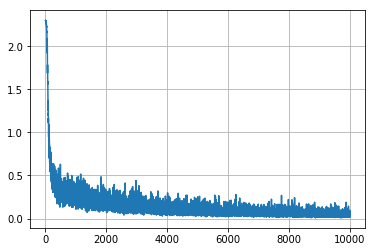

In [16]:
plt.plot(train_loss_list)
plt.grid(True)

### 正解率の推移

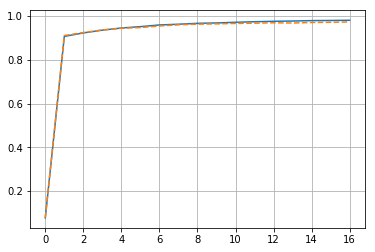

In [17]:
plt.plot(train_acc_list, '-', test_acc_list, '--')
plt.grid(True)

## 学習済モデルを使用した予測

In [18]:
y_test = network.predict(x_test)

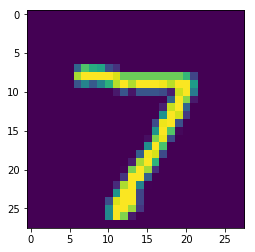

Teach: 7
Predict: 7


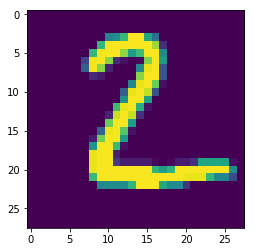

Teach: 2
Predict: 2


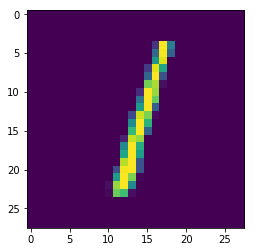

Teach: 1
Predict: 1


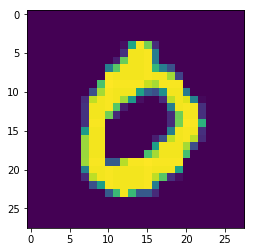

Teach: 0
Predict: 0


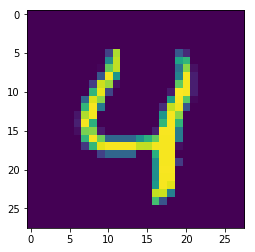

Teach: 4
Predict: 4


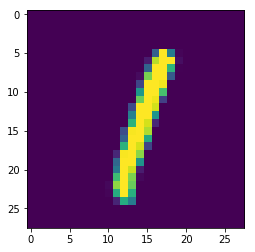

Teach: 1
Predict: 1


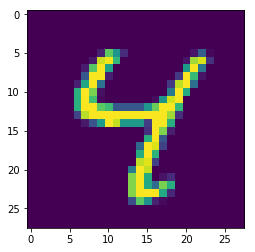

Teach: 4
Predict: 4


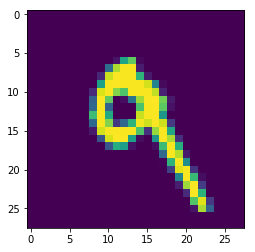

Teach: 9
Predict: 9


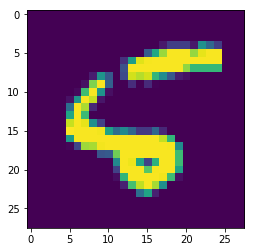

Teach: 5
Predict: 5


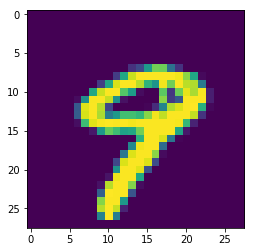

Teach: 9
Predict: 9


In [19]:
for idx in range(10):
    img = x_test[idx]
    label = t_test[idx]
    
    plt.imshow(img.reshape(28, 28))
    plt.show()
    
    print("Teach: {0}".format(label.argmax()))    
    print("Predict: {0}".format(y_test[idx].argmax()))